# General Experiment.
Modular setup of the AL experiments

## libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import laplace
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from batchbald_redux import repeated_mnist, active_learning, batchbald
from main.models import BayesianConvNet, ConvNet
from main.utils import save_experiment, load_experiment
from laplace.curvature import BackPackGGN, CurvlinopsEF, CurvlinopsGGN, AsdfghjklGGN, AsdfghjklEF
from main.laplace_batch import get_laplace_batch


%reload_ext autoreload
%autoreload 2

c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data and experiment parameters

In [2]:
# loading data
train_dataset, test_dataset = repeated_mnist.create_MNIST_dataset()

# number of initial samples 
num_initial_samples = 40
num_classes = 10

# get indices of initial samples
initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)

# Experiment parameters

## Active learning parameters
max_training_samples = 100  # Maximum number of samples to acquire from the pool dataset 
acquisition_batch_size = 2  # Number of samples to acquire in each acquisition step

## Training parameters
test_batch_size = 512  # Batch size for testing
batch_size = 64  # Batch size for training
scoring_batch_size = 64  # Batch size for scoring 
training_iterations_nn = 4096 * 6  # Number of training iterations (batches) to run
training_iterations_la = 2**8  # Number of training iterations (batches) to run

## Model parameters
hessian_structure = "kron"  # Options: "full", "kron", "lowrank" and "diag"
subset_of_weights = "last_layer"  # Options: "all", "subnetwork" and "last_layer"
backend = CurvlinopsGGN  # Options: CurvlinopsGGN, CurvlinopsEF, AsdfgjklEF, AsdfghjklGGN, BackPackGGN
al_method = 'bald'  # Options: "logit_entropy", "probit_entropy", "entropy", "bald"
temperature = 1  # Temperature for LA model

kwargs = {"num_workers": 1, "pin_memory": True}

use_cuda = torch.cuda.is_available()
device = "cuda" if use_cuda else "cpu"

print(f"use_cuda: {use_cuda}")

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

active_learning_data = active_learning.ActiveLearningData(train_dataset)

# Split off the initial samples first.
active_learning_data.acquire(initial_samples)

# THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
active_learning_data.extract_dataset_from_pool(55000)

train_loader_nn = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

train_loader_la = torch.utils.data.DataLoader(
    active_learning_data.training_dataset,
    sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations_nn),
    batch_size=batch_size,
    **kwargs,
)

pool_loader = torch.utils.data.DataLoader(
    active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
)

use_cuda: False


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\torch\utils\data\sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."


## Running Experiment

In [3]:
# Run experiment
test_accs = []
test_loss = []
added_indices = []
added_labels = []

pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
loss_fn = nn.NLLLoss()

while True:
    model = ConvNet().to(device=device)
    optimizer = torch.optim.Adam(model.parameters())

    model.train()

    # Train
    for data, target in tqdm(train_loader_nn, desc="Training", leave=False):
        data = data.to(device=device)
        target = target.to(device=device)

        optimizer.zero_grad()

        prediction = F.log_softmax(model(data).squeeze(1), dim=1)
        loss = loss_fn(prediction, target)

        loss.backward()
        optimizer.step()

    # Test
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Testing", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            prediction = model(data).squeeze(1)
            loss += loss_fn(prediction, target)

            prediction = prediction.argmax(dim=1)
            correct += prediction.eq(target.view_as(prediction)).sum().item()

    loss /= len(test_loader.dataset)
    test_loss.append(loss)

    percentage_correct = 100.0 * correct / len(test_loader.dataset)
    test_accs.append(percentage_correct)

    print(
        "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
            loss, correct, len(test_loader.dataset), percentage_correct
        )
    )

    if len(active_learning_data.training_dataset) >= max_training_samples:
        break

    # Acquire new batch from pool samples using entropy acquisition function
    N = len(active_learning_data.pool_dataset)
    
    la = laplace.Laplace(
                        model,
                        likelihood="classification",
                        subset_of_weights=subset_of_weights,
                        hessian_structure=hessian_structure,
                        backend=backend,
                        temperature=temperature/len(active_learning_data.training_dataset),
                     )
    
    print('Fitting Laplace')
    la.fit(train_loader_la, progress_bar=True)

    print('Optimizing prior precision')
    la.optimize_prior_precision(method='marglik', verbose=True, pred_type='glm', link_approx='probit')

    candidate_batch = get_laplace_batch(model=la, pool_loader=pool_loader,
                                            acquisition_batch_size=acquisition_batch_size,
                                            device=device, 
                                            method=al_method)


    targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
    dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

    print("Dataset indices: ", dataset_indices)
    print("Scores: ", candidate_batch.scores)
    print("Labels: ", targets[candidate_batch.indices])

    active_learning_data.acquire(candidate_batch.indices)
    added_indices.append(dataset_indices)
    added_labels.append(targets[candidate_batch.indices])
    pbar.update(len(dataset_indices))

Training Set Size:  40%|████      | 40/100 [00:00<?, ?it/s]

Test set: Average loss: -0.0284, Accuracy: 6849/10000 (68.49%)
Fitting Laplace


c:\Users\vince\Documents\Statistics\TT\msc_thesis\.venv\Lib\site-packages\laplace\baselaplace.py:409: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


Optimizing prior precision
Optimized prior precision is tensor([75.0312]).


Training Set Size:  42%|████▏     | 42/100 [00:49<24:06, 24.94s/it]

Dataset indices:  [6044 8185]
Scores:  [0.24633169174194336, 0.23184537887573242]
Labels:  tensor([2, 1])


Test set: Average loss: -0.0109, Accuracy: 6956/10000 (69.56%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([73.9427]).


Training Set Size:  44%|████▍     | 44/100 [01:42<24:04, 25.80s/it]

Dataset indices:  [52981 10914]
Scores:  [0.1440523862838745, 0.12624579668045044]
Labels:  tensor([5, 0])


Test set: Average loss: -0.0174, Accuracy: 7394/10000 (73.94%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([77.3548]).


Training Set Size:  46%|████▌     | 46/100 [02:36<23:38, 26.27s/it]

Dataset indices:  [37642 38025]
Scores:  [0.2518647313117981, 0.18742328882217407]
Labels:  tensor([0, 0])


Test set: Average loss: -0.0158, Accuracy: 7482/10000 (74.82%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([80.8615]).


Training Set Size:  48%|████▊     | 48/100 [03:29<22:54, 26.43s/it]

Dataset indices:  [48038 39827]
Scores:  [0.16720759868621826, 0.10479706525802612]
Labels:  tensor([3, 8])


Test set: Average loss: -0.0284, Accuracy: 7815/10000 (78.15%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([93.1616]).


Training Set Size:  50%|█████     | 50/100 [04:21<21:53, 26.27s/it]

Dataset indices:  [45291 45300]
Scores:  [0.2724990248680115, 0.18758785724639893]
Labels:  tensor([6, 6])


Test set: Average loss: -0.0277, Accuracy: 7893/10000 (78.93%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([82.4938]).


Training Set Size:  52%|█████▏    | 52/100 [05:14<21:06, 26.38s/it]

Dataset indices:  [ 5155 25489]
Scores:  [0.1089712381362915, 0.08311975002288818]
Labels:  tensor([4, 6])


Test set: Average loss: -0.0246, Accuracy: 7748/10000 (77.48%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([94.4517]).


Training Set Size:  54%|█████▍    | 54/100 [06:07<20:14, 26.40s/it]

Dataset indices:  [36216 44133]
Scores:  [0.1244126558303833, 0.11172378063201904]
Labels:  tensor([3, 2])


Test set: Average loss: -0.0271, Accuracy: 7761/10000 (77.61%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([88.2259]).


Training Set Size:  56%|█████▌    | 56/100 [07:01<19:30, 26.61s/it]

Dataset indices:  [48492 21491]
Scores:  [0.10491865873336792, 0.09784162044525146]
Labels:  tensor([6, 4])


Test set: Average loss: -0.0258, Accuracy: 7848/10000 (78.48%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([86.0782]).


Training Set Size:  58%|█████▊    | 58/100 [07:54<18:35, 26.57s/it]

Dataset indices:  [47757 46081]
Scores:  [0.14905130863189697, 0.12844836711883545]
Labels:  tensor([5, 7])


Test set: Average loss: -0.0229, Accuracy: 8030/10000 (80.30%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([91.2724]).


Training Set Size:  60%|██████    | 60/100 [08:48<17:47, 26.69s/it]

Dataset indices:  [40205  1117]
Scores:  [0.14045941829681396, 0.11185777187347412]
Labels:  tensor([3, 6])


Test set: Average loss: -0.0201, Accuracy: 8076/10000 (80.76%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([93.3278]).


Training Set Size:  62%|██████▏   | 62/100 [09:40<16:47, 26.50s/it]

Dataset indices:  [47704 50530]
Scores:  [0.10717067122459412, 0.10585582256317139]
Labels:  tensor([0, 8])


Test set: Average loss: -0.0263, Accuracy: 8139/10000 (81.39%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([85.0811]).


Training Set Size:  64%|██████▍   | 64/100 [10:34<15:54, 26.52s/it]

Dataset indices:  [38770 50395]
Scores:  [0.08409518003463745, 0.08314001560211182]
Labels:  tensor([2, 5])


Test set: Average loss: -0.0259, Accuracy: 8113/10000 (81.13%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([92.5668]).


Training Set Size:  66%|██████▌   | 66/100 [11:26<14:59, 26.45s/it]

Dataset indices:  [18514 32992]
Scores:  [0.09316647052764893, 0.08330735564231873]
Labels:  tensor([2, 5])


Test set: Average loss: -0.0242, Accuracy: 8228/10000 (82.28%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([82.4999]).


Training Set Size:  68%|██████▊   | 68/100 [12:21<14:15, 26.74s/it]

Dataset indices:  [5630 2904]
Scores:  [0.06298166513442993, 0.062053680419921875]
Labels:  tensor([1, 0])


Test set: Average loss: -0.0236, Accuracy: 8103/10000 (81.03%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([82.1576]).


Training Set Size:  70%|███████   | 70/100 [13:15<13:23, 26.79s/it]

Dataset indices:  [52668 32445]
Scores:  [0.07744544744491577, 0.07366704940795898]
Labels:  tensor([1, 5])


Test set: Average loss: -0.0224, Accuracy: 8079/10000 (80.79%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([91.3815]).


Training Set Size:  72%|███████▏  | 72/100 [14:08<12:28, 26.74s/it]

Dataset indices:  [55319 19648]
Scores:  [0.07610398530960083, 0.07427072525024414]
Labels:  tensor([2, 7])


Test set: Average loss: -0.0287, Accuracy: 8227/10000 (82.27%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([96.9526]).


Training Set Size:  74%|███████▍  | 74/100 [15:02<11:36, 26.78s/it]

Dataset indices:  [46633 34838]
Scores:  [0.07459098100662231, 0.0667375922203064]
Labels:  tensor([8, 9])


Test set: Average loss: -0.0357, Accuracy: 8324/10000 (83.24%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([97.5420]).


Training Set Size:  76%|███████▌  | 76/100 [15:55<10:40, 26.70s/it]

Dataset indices:  [19886 26580]
Scores:  [0.08198148012161255, 0.07588827610015869]
Labels:  tensor([2, 8])


Test set: Average loss: -0.0252, Accuracy: 8299/10000 (82.99%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([96.3173]).


Training Set Size:  78%|███████▊  | 78/100 [16:48<09:47, 26.70s/it]

Dataset indices:  [ 7517 32314]
Scores:  [0.06939858198165894, 0.06676572561264038]
Labels:  tensor([4, 3])


Test set: Average loss: -0.0181, Accuracy: 8315/10000 (83.15%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([76.9916]).


Training Set Size:  80%|████████  | 80/100 [17:41<08:53, 26.68s/it]

Dataset indices:  [2800 7383]
Scores:  [0.08853113651275635, 0.07482242584228516]
Labels:  tensor([4, 3])


Test set: Average loss: -0.0331, Accuracy: 8631/10000 (86.31%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([93.7619]).


Training Set Size:  82%|████████▏ | 82/100 [18:35<08:01, 26.73s/it]

Dataset indices:  [31169 52129]
Scores:  [0.07414960861206055, 0.07156920433044434]
Labels:  tensor([1, 3])


Test set: Average loss: -0.0275, Accuracy: 8423/10000 (84.23%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([82.4826]).


Training Set Size:  84%|████████▍ | 84/100 [19:29<07:09, 26.87s/it]

Dataset indices:  [27806 39620]
Scores:  [0.07250839471817017, 0.06301331520080566]
Labels:  tensor([0, 0])


Test set: Average loss: -0.0287, Accuracy: 8482/10000 (84.82%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([98.3950]).


Training Set Size:  86%|████████▌ | 86/100 [20:23<06:15, 26.84s/it]

Dataset indices:  [57434  9514]
Scores:  [0.06376731395721436, 0.05611097812652588]
Labels:  tensor([8, 5])


Test set: Average loss: -0.0258, Accuracy: 8616/10000 (86.16%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([92.8480]).


Training Set Size:  88%|████████▊ | 88/100 [21:17<05:22, 26.85s/it]

Dataset indices:  [52761 17740]
Scores:  [0.07535958290100098, 0.06666791439056396]
Labels:  tensor([9, 4])


Test set: Average loss: -0.0281, Accuracy: 8731/10000 (87.31%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([104.7367]).


Training Set Size:  90%|█████████ | 90/100 [22:11<04:28, 26.90s/it]

Dataset indices:  [30324 14341]
Scores:  [0.06251204013824463, 0.05874216556549072]
Labels:  tensor([8, 9])


Test set: Average loss: -0.0275, Accuracy: 8715/10000 (87.15%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([97.6762]).


Training Set Size:  92%|█████████▏| 92/100 [23:04<03:34, 26.80s/it]

Dataset indices:  [15730 28517]
Scores:  [0.06589996814727783, 0.050775766372680664]
Labels:  tensor([1, 4])


Test set: Average loss: -0.0258, Accuracy: 8767/10000 (87.67%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([84.4913]).


Training Set Size:  94%|█████████▍| 94/100 [23:57<02:40, 26.73s/it]

Dataset indices:  [ 3393 19294]
Scores:  [0.05799508094787598, 0.05444204807281494]
Labels:  tensor([1, 4])


Test set: Average loss: -0.0265, Accuracy: 8797/10000 (87.97%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([78.4836]).


Training Set Size:  96%|█████████▌| 96/100 [24:51<01:46, 26.74s/it]

Dataset indices:  [46327 22830]
Scores:  [0.05455946922302246, 0.050382018089294434]
Labels:  tensor([7, 6])


Test set: Average loss: -0.0290, Accuracy: 8747/10000 (87.47%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([86.6339]).


Training Set Size:  98%|█████████▊| 98/100 [25:44<00:53, 26.74s/it]

Dataset indices:  [19173 54394]
Scores:  [0.05072808265686035, 0.04883074760437012]
Labels:  tensor([5, 8])


Test set: Average loss: -0.0271, Accuracy: 8664/10000 (86.64%)
Fitting Laplace
Optimizing prior precision
Optimized prior precision is tensor([80.1034]).


Training Set Size: 100%|██████████| 100/100 [26:38<00:00, 26.80s/it]

Dataset indices:  [45940 18938]
Scores:  [0.040011048316955566, 0.03961837291717529]
Labels:  tensor([3, 5])


Test set: Average loss: -0.0295, Accuracy: 8835/10000 (88.35%)


## Storing results

In [4]:
experiment_id = np.random.randint(1000, 9999)


In [5]:
params_dict = {
    'num_initial_samples': num_initial_samples,
    'num_classes': num_classes,
    'max_training_samples': max_training_samples,
    'acquisition_batch_size': acquisition_batch_size,
    'test_batch_size': test_batch_size,
    'batch_size': batch_size,
    'scoring_batch_size': scoring_batch_size,
    'training_iterations_nn': training_iterations_nn,
    'training_iterations_la': training_iterations_la,
}

# generate a unique experiment id of 3 digits (just to make sure don't override things, clean up later)
save_experiment(f'{al_method}_{hessian_structure}_{subset_of_weights}_K{acquisition_batch_size}_{experiment_id}',
                params_dict, {
    'test_accs': test_accs,
    'test_loss': test_loss,
    'added_indices': added_indices
})

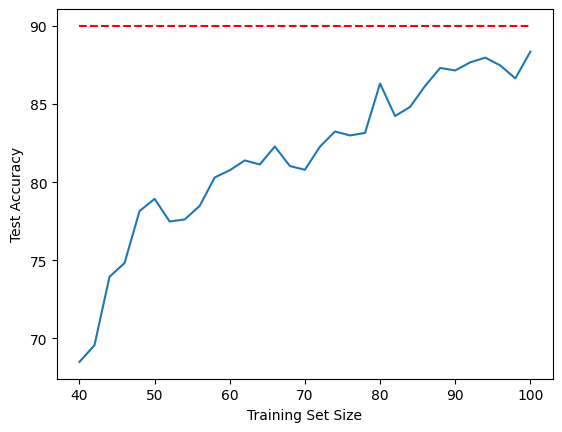

In [6]:
plt.plot(np.arange(start=num_initial_samples, stop=max_training_samples + acquisition_batch_size, step=acquisition_batch_size), test_accs)
plt.xlabel("Training Set Size")
plt.ylabel("Test Accuracy")
plt.hlines(90, num_initial_samples, max_training_samples, colors='r', linestyles='dashed')
plt.savefig(f'plots/{al_method}_{hessian_structure}_{subset_of_weights}_K{acquisition_batch_size}_{experiment_id}.png')
plt.show()
